In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import statsmodels.api as sm
import statistics as st
import pylab 
import matplotlib.pyplot as plt
from math import sqrt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from scipy import stats
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/students-performance-in-exams/StudentsPerformance.csv


Считаем данные и переименуем  колонки, это пригодится дальше

In [3]:
df = pd.read_csv("/kaggle/input/students-performance-in-exams/StudentsPerformance.csv")
df = df.rename(columns={"math score": "math_score", "reading score": "reading_score","writing score": "writing_score","test preparation course":"test_preparation_course"})
df

,gender,race/ethnicity,parental level of education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95
996,male,group C,high school,free/reduced,none,62,55,55
997,female,group C,high school,free/reduced,completed,59,71,65
998,female,group D,some college,standard,completed,68,78,77


Таблица состоит из номинотивных и количественных переменных

Меры центральной тенденции

In [24]:
from collections import Counter
moda = Counter(df['math_score']).most_common(1) #Наиболее часто встречающаяся велечина
moda_statistics = stats.mode(df['math_score'])
print('mode',moda[0],moda_statistics)
median = df['math_score'].median()#значение находящееся посередине упорядоченного множества
mean = df['math_score'].mean()#среднее
print(f'median is {median},mean is {mean}')

mode (65, 36) ModeResult(mode=array([65]), count=array([36]))
median is 66.0,mean is 66.089


Мера изменчивости

In [4]:
import statistics as st
rang = max(df['math_score']) - min(df['math_score'])#Размах
D = sum(list(((x - df['math_score'].mean()) ** 2)for x in df['math_score']))/ (len(df) - 1)#Дисперсия - средний квадрат отклонений
sd = sqrt(D) #стандортное отклонение
print(f'D is {D},sd is {sd}')
st.variance(df['math_score'])

D is 229.91899799799847,sd is 15.163080096009468


229.918997997998

Z преобразование D = 1, mean = 0

Необходимо чтобы сравнивать разные по размаху  показатели
Например: В одной школе 100 бальная система, а в другой 10 бальная

In [5]:
z = list(((x - df['math_score'].mean()) / sd) for x in df['math_score'])
z_1 = stats.zscore(df['math_score'])
print(z[0],z_1[0])

0.3898284492710438 0.3900235098032764


**Центральная предельная теорема**

Если взять выборку из ген.совокупности их среднее будет стремиться к среднему ген.совокупности 

In [6]:
se = sd/sqrt(len(df['math_score'])) #отклонения среднего выборки от генеральной совокупности
se_frame = stats.sem(df['math_score'])
#Правило 2х и 3х сигм
sigm2 = 1.96 * se
sigm3 = 2.58*se
print(se, se_frame)
print(f'С вероятностью 95% среднее количество балов по математике находится в области от {mean - sigm2} до {mean + sigm2}\n'
      f'С вероятностью 99% среднее количество балов по математике находится в области от {mean - sigm3} до {mean + sigm3}')

0.47949869446954546 0.4794986944695449
С вероятностью 95% среднее количество балов по математике находится в области от 65.14918255883968 до 67.02881744116031
С вероятностью 99% среднее количество балов по математике находится в области от 64.85189336826858 до 67.32610663173142


**Статистическая проверка гипотезы**

Сделаем предположение, что средний балл по математике равен 70.


* H0 = 70
* H1 != 70

In [16]:
H0 = 67.03
z = (mean - H0) / se
if (stats.norm.sf(abs(z)) * np.float64(2)) < np.float64(0.05):
    print(f'Гипотезу, что среднее равно {H0} можно отклонить, так как p-value = {(stats.norm.sf(abs(z)) * np.float64(2))} < 0.05, z = {z}')
else:
    print(f'Гипотезу, что среднее равно {H0} нельзя отклонить, так как p-value = {(stats.norm.sf(abs(z)) * np.float64(2))} > 0.05, z = {z}')


Гипотезу, что среднее равно 67.03 можно отклонить, так как p-value = 0.04970822737931076 < 0.05, z = -1.962466239957132


**Критерий Т стьюдента**

Берем репрезентативную выборку и делим на две группы(Мужчины и женщины)

In [3]:
male = df.loc[df['gender'] == 'male']
female = df.loc[df['gender'] == 'female']

H0: Mm = Mf
H1: Mm != Mf

In [20]:
def t(Xm, Xf,sdm,sdf,nm,nf):
    a = Xm- Xf
    mm = (sdm ** 2) / nm
    mf = (sdf ** 2) / nf
    t = a/((mm + mf)** (1/2))
    return t

In [22]:
Xm = male['math_score'].mean()
Xf = female['math_score'].mean()
sdm = male.std()['math_score']
sdf = female.std()['math_score']
nm = male.shape[0]
nf = female.shape[0]
t(Xm, Xf,sdm,sdf,nm,nf)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  after removing the cwd from sys.path.


5.398000564160736

In [6]:
st, pv = stats.ttest_ind(male['math_score'], female['math_score'])
if pv<0.05:
    print(f'Среднее двух репрезанетативных выборок отличается, есть основания отклонить H0 так как {pv} < 0.05')
else:
    print(f'Среднее двух репрезанетативных выборок отличается, нет оснований отклонить H0 так как {pv} > 0.05')

Среднее двух репрезанетативных выборок отличается, есть основания отклонить H0 так как 9.120185549328822e-08 < 0.05


5.383245869828983

**U-тест Манна-Уитни**, применяется когда не все условия выполнимы для Т теста

In [7]:
st, pv = stats.mannwhitneyu(male['math_score'], female['math_score'])
if pv<0.05:
    print(f'Среднее двух репрезанетативных выборок отличается, есть основания отклонить H0 так как {pv} < 0.05')
else:
    print(f'Среднее двух репрезанетативных выборок отличается, нет оснований отклонить H0 так как {pv} > 0.05')

Среднее двух репрезанетативных выборок отличается, есть основания отклонить H0 так как 4.279076773478767e-07 < 0.05


**Как понять что наша выбока распределена нормально?**

**1. QQ plot**

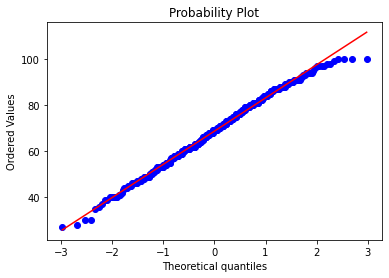

In [4]:
import scipy.stats as stats
import pylab 
stats.probplot(male['math_score'], dist="norm", plot=pylab)
pylab.show()

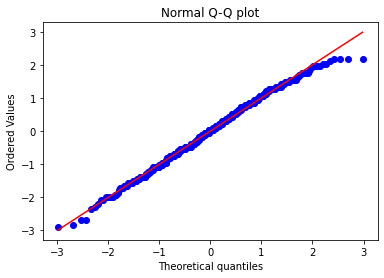

In [17]:
%matplotlib inline
z = (male['math_score']-np.mean(male['math_score']))/np.std(male['math_score'])
stats.probplot(z, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()


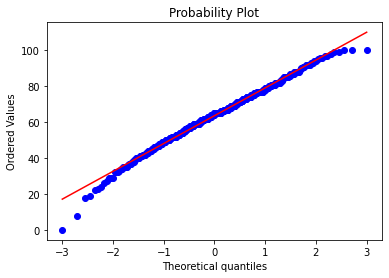

In [16]:
stats.probplot(female['math_score'], dist="norm", plot=pylab)
pylab.show()

**Шапиро тест**

In [6]:
st,pv = stats.shapiro(male['math_score'])
if pv < 0.05:
    print(f'Распределение не норамальное так как {pv} < 0.05')

Распределение не норамальное так как 0.03796108067035675 < 0.05


In [11]:
np.corrcoef((male['math_score']), qnorm(ppoints(length(male['math_score']))))

NameError: name 'qnorm' is not defined

In [35]:
st,pv = stats.shapiro(female['math_score'])
if pv < 0.05:
    print(f'Распределение не норамальное так как {pv} < 0.05')

Распределение не норамальное так как 0.0035164919681847095 < 0.05


Как я говорил в видео, для t - test есть требование к нормальности данных. Означает ли это, что t - test нельзя использовать, если данные ненормально распределены?

Вопрос с подвохом. Скажем так, если у самого признака в выборках нормальное распределение, то для t - test все очень хорошо, а вот если нет ... то возможны всяческие нежелательные спецэффекты. Но при этом на практике, можно встретиться с применением t - test даже на ненормальных данных, и это нормально!)

In [6]:
U1, p = stats.mannwhitneyu(male['math_score'],female['math_score'], alternative='two-sided')
p

4.279076773478767e-07

**Однофакторный дисперсионный анализ**
****

In [4]:
A = df.loc[df['race/ethnicity'] == 'group A']
B = df.loc[df['race/ethnicity'] == 'group B']
C = df.loc[df['race/ethnicity'] == 'group C']
D = df.loc[df['race/ethnicity'] == 'group D']
E = df.loc[df['race/ethnicity'] == 'group E']
x = [A['math_score'].tolist(),B['math_score'].tolist(),C['math_score'].tolist(),D['math_score'].tolist(),E['math_score'].tolist()]

Распределение норамальное так как 0.8545348644256592 > 0.05


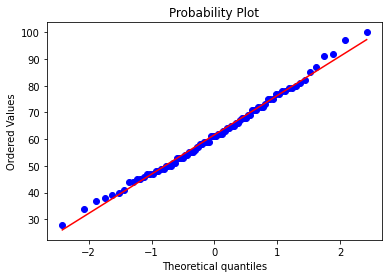

Распределение не норамальное так как 0.010394944809377193 < 0.05


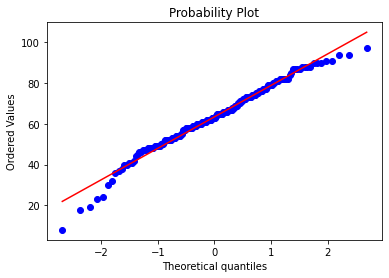

Распределение не норамальное так как 0.017411569133400917 < 0.05


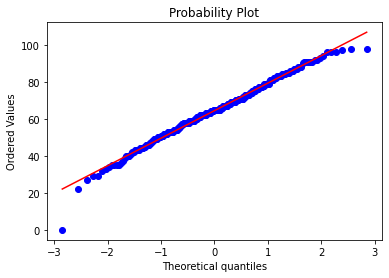

Распределение норамальное так как 0.05927419662475586 > 0.05


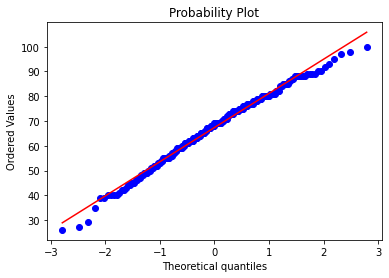

Распределение не норамальное так как 0.01849539391696453 < 0.05


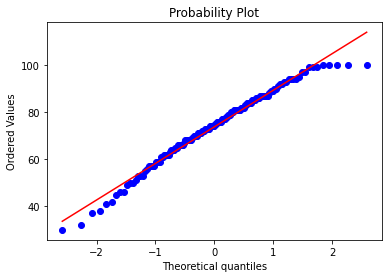

In [11]:
for i in x:
    st,pv = stats.shapiro(i['math_score'])
    if pv < 0.05:
        print(f'Распределение ненорамальное так как {pv} < 0.05')
    else:
        print(f'Распределение норамальное так как {pv} > 0.05')
    stats.probplot(i['math_score'], dist="norm", plot=pylab)
    pylab.show()

In [6]:
def listmerge1(lstlst):
    all=[]
    for lst in lstlst:
        for el in lst:
            all.append(el)
    return all
def F(df,x):
    from statistics import mean
    mean_by_group = []
    #mean_tot = stats.mean(df[column])
    mean_tot = mean(listmerge1(x))
    SSB = 0
    SSW = 0
    for i in x:
        avg1 = i.mean()
        mean_by_group.append(avg1)
        SSB += len(i) * ((avg1 - mean_tot)** 2)
        for ii in i:
            SSW += (ii - avg1) ** 2
    dfsb = (len(x) - 1)
    dfwg = (len(listmerge1(x)) - len(x))
    MSbg = SSB / dfsb
    MSwg = SSW / dfwg
    F = MSbg / MSwg
    if SSB > SSW:
        print('Группы различаются так как SSB > SSW')
    else:
        print('Группы не различаются так как SSB < SSW')
    print(dfsb, dfwg,SSB,SSW)
    return F
x = [A['math_score'],B['math_score'],C['math_score'],D['math_score'],E['math_score']]
av = F(df,x)
av

Группы не различаются так как SSB < SSW
4 995 12728.816698247943 216960.2623017516


14.593885166332662

In [11]:
statistic, pvalue = stats.f_oneway(*x)
if pvalue < 0.05/len(x):
    print(f'Данных достаточно, чтобы отклонить H0(М1=М2=М3), так как {pvalue} < {0.05/len(x)}')

Данных достаточно, чтобы отклонить H0(М1=М2=М3), так как 1.3732194030370688e-11 < 0.01


In [13]:
d = {'col1': [1, 1, 1, 2, 2, 2,3,3,3], 'col2': [3,1,2,5,3,4,7,6,5]}
df_check = pd.DataFrame(data=d)
one = df_check.loc[df_check['col1'] == 1]
two = df_check.loc[df_check['col1'] == 2]
three = df_check.loc[df_check['col1'] == 3]
x = [one['col2'],two['col2'],three['col2']]
f = F(df_check, x)
f

Группы различаются так как SSB > SSW
2 6 24.0 6.0


12.0

In [12]:
stats.f_oneway(one['col2'],two['col2'],three['col2'])

F_onewayResult(statistic=12.0, pvalue=0.008000000000000002)

**Множественные сравнения в ANOVA**
****

Поправка Бен-Ферони

Используется так как если брать 1000 групп из ГС, то значение показателей при 0,05 стремится к нулю

In [12]:
statistic, pvalue = stats.f_oneway(*x)
if pvalue < 0.05/len(x):
    print(f'Данных достаточно, чтобы отклонить H0(М1=М2=М3), так как {pvalue} < {0.05/len(x)}')

Данных достаточно, чтобы отклонить H0(М1=М2=М3), так как 1.3732194030370688e-11 < 0.01


Поправка Тьюки

Более либеральная поправка

In [34]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
p = pairwise_tukeyhsd(endog=df["math_score"],groups=df['parental level of education'],alpha=0.05)
print(p)

            Multiple Comparison of Means - Tukey HSD, FWER=0.05             
      group1             group2      meandiff p-adj   lower    upper  reject
----------------------------------------------------------------------------
associate's degree bachelor's degree   1.5069 0.9503  -3.3587  6.3726  False
associate's degree       high school  -5.7451 0.0013  -9.9311 -1.5591   True
associate's degree   master's degree   1.8629 0.9578  -4.3927  8.1185  False
associate's degree      some college  -0.7546 0.9948  -4.7903  3.2812  False
associate's degree  some high school  -4.3857 0.0418   -8.676 -0.0954   True
 bachelor's degree       high school  -7.2521 0.0005 -12.2284 -2.2757   True
 bachelor's degree   master's degree   0.3559    1.0  -6.4539  7.1658  False
 bachelor's degree      some college  -2.2615 0.7676  -7.1122  2.5892  False
 bachelor's degree  some high school  -5.8926 0.0119  -10.957 -0.8282   True
       high school   master's degree    7.608 0.0084   1.2659 13.9501   True

**МногофакторныЙ ANOVA**
****

Двухфакторный дисперсионный анализ

In [33]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
model = ols('math_score ~ (test_preparation_course)*(gender)', data=df).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
test_preparation_course,7170.996015,1.0,33.060780,1.187245e-08
gender,6399.209637,1.0,29.502577,7.018859e-08
test_preparation_course:gender,0.907979,1.0,0.004186,9.484258e-01
Residual,216035.801152,996.0,NaN,NaN


Влияние пола и готовился ли человек к жкзаменам влияет на уровень экспрессии

<AxesSubplot:xlabel='lunch', ylabel='math_score'>

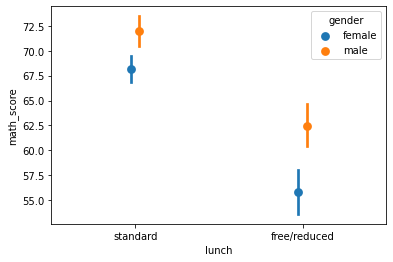

In [37]:
sns.pointplot(x=df['lunch'], y=df.math_score, hue=df.gender, data=df, dodge=True, linestyles=['', ''])

**Корреляция**

<AxesSubplot:>

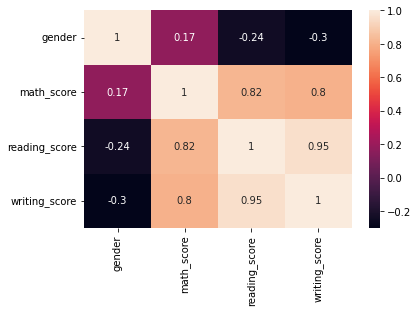

In [30]:
df['gender'] = pd.factorize(df['gender'])[0] + 1
df_new = df[['math_score', 'gender']]
sns.heatmap(df.corr(), annot = True)

**Ковариация** (ко - совместная, вариация - изменчивость). Мера линейной зависимости двух случайных величин.

In [14]:
def covar(x,y):
    covariat = 0
    for xi, yi in zip(x,y):
        covariat += ((xi - x.mean()) * (yi - x.mean())) / (len(x) - 1)
    return covariat
print(np.cov(df['math_score'],df['reading_score'], bias = False), 'матрица из ковариации и дисперсии')
print(st.variance(df['math_score']), 'дисперсия')
covar(df['math_score'],df['reading_score'])


[[229.918998   180.99895796]
 [180.99895796 213.1656046 ]] матрица из ковариации и дисперсии
229.918997997998 дисперсия


180.99895795795823

In [18]:
def corelation(x,y):
    numerator = 0
    sumx = 0
    sumy = 0
    for xi, yi in zip(x,y):
        numerator += ((xi - x.mean()) * (yi - x.mean()))
        sumx += (xi - x.mean()) ** 2
        sumy += (yi - y.mean()) ** 2
    r = numerator / (sqrt(sumx * sumy))
    return r
print(corelation(df['math_score'],df['reading_score']))
np.corrcoef(df['math_score'],df['reading_score'])

0.8175796636720538


array([[1.        , 0.81757966],
       [0.81757966, 1.        ]])

**Регрессия с одной независимой переменной**

Регрессия позволяет проверять зависимость одной количественной зависимой переменной от других независимых

y = b0 + b1x формула линейной регрессии
* b0 интерсепт
* b1 наклон

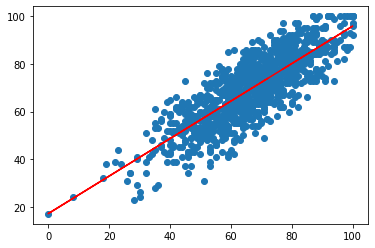

In [6]:
y1 = df['reading_score']
x = df['math_score']
b1 = y1.std()/x.std()*np.corrcoef(x, y1)[0][1]
b0 = y1.mean() - b1*x.mean()
f = lambda x: b0 + b1*x
y_pred = f(x)
plt.scatter(x, y1)
plt.plot(x, y_pred, color='r')
plt.show()

Гипотеза о значимости взаимосвязи и коэфицент детерминации

H0: b1 = 0
H1: b1 != 0

Гипотеза состоит в том, что линейная регрессия никак не объясняет зависимость

In [7]:
from scipy.stats import linregress

slope, intercept, r, p, std_err =  linregress(x, y1)
print(slope, intercept, r, p, std_err)
print(b1,b0)

0.787229239575645 17.141806785685198 0.8175796636720546 1.7877531099034724e-241 0.017550488896938256
0.7872292395756445 17.141806785685226


In [8]:
print(f'''
slope = {slope:.2f}
intercept = {intercept:.2f}
r = {r:.2f}
r squared = {(r ** 2):.2f} %объясняется моделью
p = {p:.5f}
std_err = {std_err:.3f}
''')


slope = 0.79
intercept = 17.14
r = 0.82
r squared = 0.67 %объясняется моделью
p = 0.00000
std_err = 0.018



**Условия приминения линейной регрессии:**
* Линейная взаимосвязь Х и У
* Нормальное распределение остатков
* Гомоскеданичность

Распределение норамальное так как 0.05210939049720764 > 0.05


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

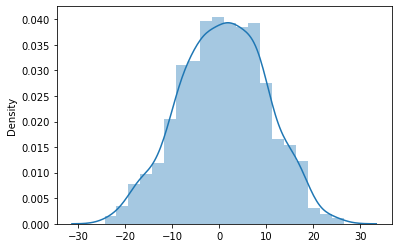

In [20]:
reg = sm.OLS(y1, x).fit()
st,pv = stats.shapiro(reg.resid)
if pv < 0.05:
    print(f'Распределение не норамальное так как {pv} < 0.05')
else:
    print(f'Распределение норамальное так как {pv} > 0.05')
sns.distplot(reg.resid)

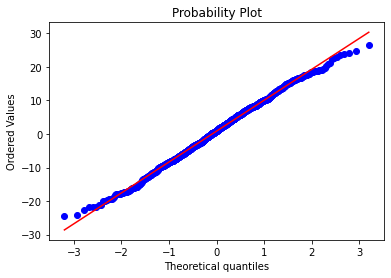

In [21]:
stats.probplot(reg.resid, dist="norm", plot=pylab)
pylab.show()

Остатки гомоскеданичны(симметрично выглядят)
Дисперсия гомогенна так как 0.9459323349068632 > 0.05


<AxesSubplot:xlabel='math_score', ylabel='writing_score'>

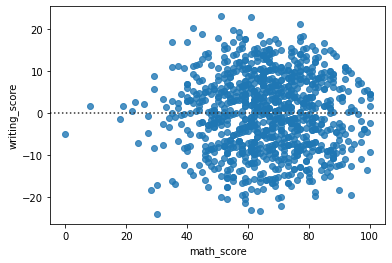

In [5]:
print('Остатки гомоскеданичны(симметрично выглядят)')
stat, p = stats.bartlett(df['math_score'],df['writing_score'])
print(f'Дисперсия не гомогенна так как {p} < 0.05' if p < 0.05 else f'Дисперсия гомогенна так как {p} > 0.05' )
sns.residplot(x='math_score',y='writing_score', data=df)

**Множественная регрессия**

In [23]:
import statsmodels.formula.api as sm
result = smf.ols(formula="writing_score ~ reading_score + math_score", data=df).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          writing_score   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     5214.
Date:                Tue, 10 Jan 2023   Prob (F-statistic):               0.00
Time:                        09:51:30   Log-Likelihood:                -2920.0
No. Observations:                1000   AIC:                             5846.
Df Residuals:                     997   BIC:                             5861.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -1.1608      0.699     -1.662

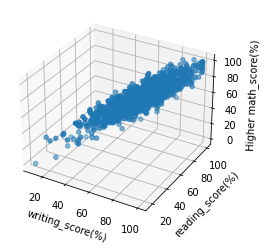

In [29]:
data_crop = df[['writing_score', 'reading_score', 'math_score']]
data_crop.head()
writing_score, reading_score, math_score = [column for column in data_crop.values.T]

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=writing_score, ys=reading_score, zs=math_score)

ax.set_xlabel('writing_score(%)')
ax.set_ylabel('reading_score(%)')
ax.set_zlabel('Higher math_score(%)')

plt.show()